In [1]:
%pylab inline
import pandas as pd
import sys,os,time
import void_library as VL
import h5py
import MAS_library as MASL
import Pk_library as PKL

Populating the interactive namespace from numpy and matplotlib


# Este notebook sirve como ejemplo de la pipeline del analisis completo de voids + lagrangian bias model utilizando PyLians.

In [2]:
# read data

pathfields   = '/home/arodriguez/BACCO/bias-voids/IATE/fields_smooth/k0.75_4f/'
R_sm = 6
sim = np.load(pathfields+'simulation_smooth_'+str(R_sm)+'.npy').astype(np.float32)

## Void identification

In [ ]:
# parameters of the void finder
BoxSize    = 1440.0 #Mpc/h
threshold  = -0.9
rmin = 20
rmax = 40
Radii      = np.arange(rmin,rmax, dtype=np.float32) #Mpc/h
threads1   = 16
threads2   = 4

# identify voids
V = VL.void_finder(sim, BoxSize, threshold, Radii, threads1, threads2, void_field=False)
void_pos    = V.void_pos    #positions of the void centers
void_radius = V.void_radius #radius of the voids
VSF_R       = V.Rbins       #bins in radius for VSF(void size function)
VSF         = V.void_vsf    #VSF (#voids/volume/dR)

maximum number of voids = 89106

Smoothing field with top-hat filter of radius 39.00
Density smoothing took 5.525 seconds
No cells with delta < -0.90

Smoothing field with top-hat filter of radius 38.00
Density smoothing took 5.516 seconds
Searching underdense cells took 0.157 seconds
Found 00000030 cells below threshold
Sorting took 0.000 seconds
Mode = 0    :   Ncells = 15   :   threads = 4
Found 000002 voids with radius R =38.000 Mpc/h
Found 000002 voids with radius R>=38.000 Mpc/h
Void volume filling fraction = 1.543e-04
Expected    filling fraction = 1.540e-04
Time1 = 0.001 seconds
Time2 = 0.002 seconds
void finding took 0.103 seconds

Smoothing field with top-hat filter of radius 37.00
Density smoothing took 5.502 seconds
Searching underdense cells took 0.157 seconds
Found 00000009 cells below threshold
Sorting took 0.000 seconds
Mode = 0    :   Ncells = 14   :   threads = 4
Found 000002 voids with radius R =37.000 Mpc/h
Found 000004 voids with radius R>=37.000 Mpc/h
Void volume 

In [8]:
def check_overlaps(positions, radii, box_size):
    """
    Verifica si hay partículas superpuestas en una caja periódica.

    Parameters:
        positions (numpy.ndarray): Array de posiciones de partículas, de dimensión (3, n).
        radii (numpy.ndarray): Array de radios de partículas, de longitud n.
        box_size (float): Tamaño de la caja periódica.
    
    Returns:
        bool: True si hay partículas superpuestas, False en caso contrario.
    """
    n = positions.shape[1]  # Número de partículas
    
    # Verificamos todas las combinaciones de partículas
    for i in range(n):
        for j in range(i + 1, n):
            # Calcula la distancia mínima considerando la caja periódica
            delta = positions[:, i] - positions[:, j]
            delta = delta - box_size * np.round(delta / box_size)  # Corrección periódica
            distance = np.linalg.norm(delta)
            
            # Compara con la suma de los radios
            if distance < (radii[i] + radii[j]):
                print(f"Partículas {i} y {j} están superpuestas (distancia = {distance}).")
                return True  # Se encontró una superposición
    
    print("No hay voids superpuestos.")
    return False

In [9]:
check_overlaps(void_pos, void_radius, 1440)

No hay voids superpuestos.


False

In [81]:
# guardo archivo
path_out = '/home/arodriguez/BACCO/bias-voids/IATE/voids-Pylians/'
data = {'x':void_pos[:,0],
        'y':void_pos[:,1],
        'z':void_pos[:,2],
        'r':void_radius
        }
df = pd.DataFrame(data)
#df.to_csv(path_out+'PyLvoids_'+str(R_sm)+'_rmin_'+str(rmin)+'.dat', index=False)

In [88]:
stop

NameError: name 'stop' is not defined

[]

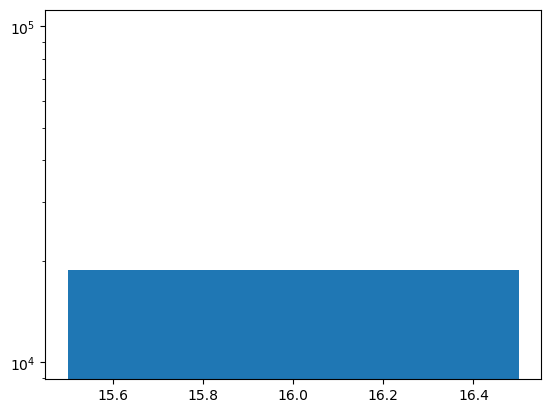

In [10]:
plt.hist(void_radius,bins=len(np.unique(void_radius)))
plt.semilogy()

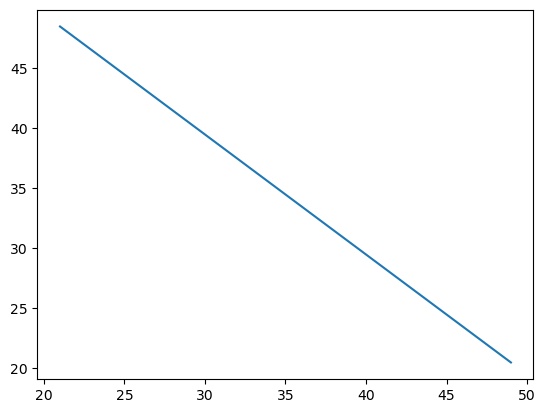

In [73]:
plt.plot(Radii[1:], VSF_R)

[]

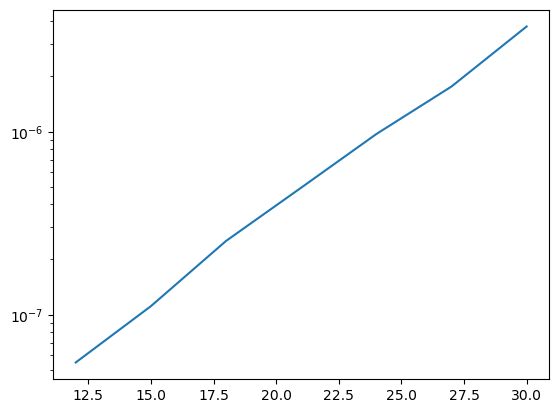

In [33]:
plt.plot(Radii[1:], VSF)
plt.semilogy()

# Chequeo funciones correlacion (perfiles)

In [12]:
cell_size = BoxSize / 540
void_pos_2 = void_pos + cell_size/2

In [13]:
# creo campo con posiciones de voids

import MAS_library as MASL

grid = 540
MAS = 'NGP'
# define 3D density field
vfield = np.zeros((grid,grid,grid), dtype=np.float32)
verbose = True
# construct 3D density field
MASL.MA(void_pos_2.astype(np.float32), vfield, BoxSize, MAS, verbose = verbose)


Using NGP mass assignment scheme
Time taken = 0.038 seconds



In [14]:
import h5py

path = '/mnt/projects/bias_mock/galaxies'
galaxies = h5py.File(path+'/galpos_RedSample_5e-04.hdf5','r')

pos = galaxies['Subhalo/SubhaloPos'][()]
galfield = np.zeros((grid,grid,grid), dtype=np.float32)
MASL.MA(pos.astype(np.float32), galfield, BoxSize, 'CIC', verbose = verbose)


Using CIC mass assignment scheme
Time taken = 0.141 seconds



In [15]:
rhofield = galfield/cell_size**3

In [16]:
delta_void = vfield/np.mean(vfield)-1
delta_gal  = galfield/np.mean(galfield)-1

In [17]:
import Pk_library as PKL

# correlation function parameters
MAS     = ['None','None']
axis    = 0
threads = 16


# compute cross-correlaton function of the two fields
CCF = PKL.XXi(delta_void, delta_gal, BoxSize, MAS, axis, threads)

# get the attributes
r      = CCF.r3D      #radii in Mpc/h
xxi0   = CCF.xi[:,0]  #monopole
xxi2   = CCF.xi[:,1]  #quadrupole
xxi4   = CCF.xi[:,2]  #hexadecapole
Nmodes = CCF.Nmodes3D #number of modes


Computing correlation function of the field...
Time to complete loop = 2.78
Time taken = 13.38 seconds


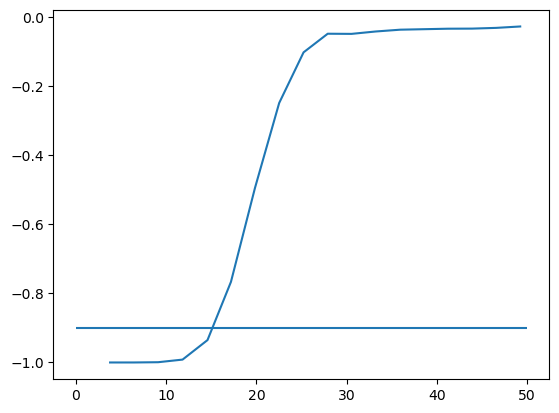

In [19]:
sel, = np.where(r<50)
plt.plot(r[sel],xxi0[sel])
plt.hlines(y=-0.9, xmin = 0, xmax = 50)

In [138]:
from scipy.integrate import quad
from scipy.interpolate import interp1d

def calculate_delta(r, xi_r, r_array):
    """
    Calcula el perfil de contraste de densidad promedio Delta(r) a partir de la función de correlación xi(r).

    Parameters:
        r (float): Radio en el que se quiere calcular Delta(r).
        xi_r (function or numpy.ndarray): Función de correlación xi(r). Puede ser una función o valores tabulados.
        r_array (numpy.ndarray): Valores de radios correspondientes a los datos tabulados de xi(r) (si aplica).

    Returns:
        float: Delta(r) (contraste de densidad promedio).
    """
    if isinstance(xi_r, np.ndarray):
        # Si xi_r está tabulado, interpolamos
        xi_interpolated = interp1d(r_array, xi_r, kind='linear', fill_value="extrapolate")
    else:
        # Si es una función directamente
        xi_interpolated = xi_r

    # Función integranda para Delta(r)
    def integrand(r_prime):
        return xi_interpolated(r_prime) * r_prime**2

    # Integramos desde 0 hasta r
    integral, _ = quad(integrand, 0, r)
    return 3 / r**3 * integral

In [146]:
# Calcular Delta(r) para todos los valores de r[sel]
delta_values = [calculate_delta(r_i, xxi0[sel], r[sel]) for r_i in r[sel]]

/home/arodriguez/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/home/arodriguez/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


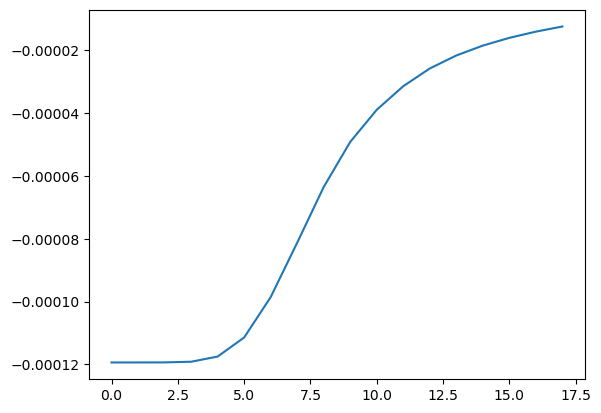

In [147]:
plt.plot(delta_values)